# 1.什么是Transfomer

Transformer模型通过自注意力机制和并行化的架构，使得模型在处理复杂的语言任务时更加高效和精确。它的出现极大地推动了自然语言处理技术的发展，为解决各种语言和序列任务提供了一种强有力的方法。



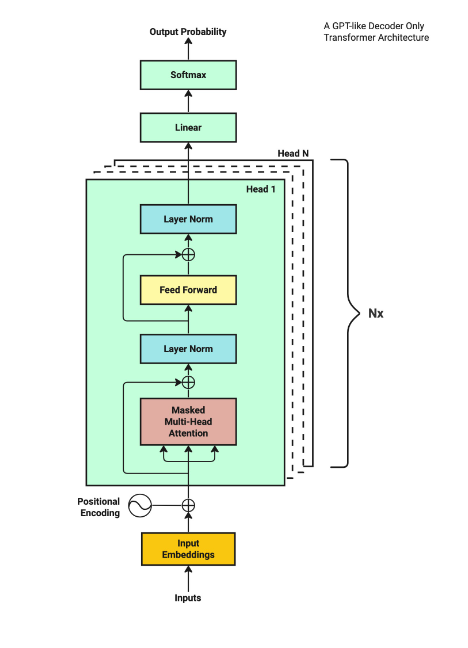

# 2.Transfomer有哪些 子模块，这些模块有什么作用

## 1. 输入嵌入（Input Embedding）
功能：将输入序列中的每个单词转换为一个固定大小的向量。<br/>
实现：通常使用一个嵌入层（类似于词向量）来完成。

## 2. 位置编码（Positional Encoding）
功能：提供单词在序列中的位置信息，补充嵌入层中缺失的顺序信息。<br/>
实现：使用正弦和余弦函数构建位置编码。

## 3. 多头自注意力机制（Multi-Head Self-Attention）
功能：让模型在计算每个位置的输出时关注输入序列的所有其他位置。<br/>
实现：通过多个“头”来执行注意力机制，使模型能够学习不同的表示。

## 4. 前馈神经网络（Feed Forward Neural Network）
功能：对通过注意力机制获得的每个位置的表示进行进一步处理。<br/>
实现：使用两个线性变换和一个激活函数。

## 5. 层归一化与残差连接（Layer Normalization and Residual Connection）
功能：通过对每一层的输出进行归一化，稳定和加速训练过程，并通过残差连接防止梯度消失。<br/>
实现：在每个子层之后应用。

# 3.Transfomer有哪些 主模块，这些模块有什么作用

## 编码器（Encoder）
功能：负责处理输入序列，生成一组特征表示。<br/>
实现：由多个相同的编码器层堆叠而成。

## 解码器（Decoder）
功能：负责根据编码器的输出和前面生成的输出序列来生成目标输出。<br/>
实现：由多个相同的解码器层堆叠而成。

## 最终输出层（Final Linear and Softmax Layer）
功能：生成输出序列的每个位置的概率分布。<br/>
实现：通常为线性层加上softmax函数。

# 4.手写大语言模型

### 4.0 安装所需依赖，定义模型超参数

#### **1.所需依赖。**

pytorch(基本库)<br/>
tiktoken(ChatGPT研发的文字转数字)<br/>
pandas(可视化数据/矩阵)

#### **2.模型超参数。**

In [1]:
#hyperparameters(超参数)

#上下文长度(用于确定一句话的输入范围，该值有多大就输入多少个词进入到模型)
_context_length = 16
#词的特征维度 值有多大就有多少维
_d_model = 64

#一次训练丢几个段话同时进入训练，丢入的一段话的长度取决于 上下文长度
_batch_size = 4
##矩阵形状为 context_length *d_model ，行由context_length组成  列由d_model组成
##一次丢进去 batch_size 个 矩阵


###多头
#多头的数量
_num_heads = 4

### 4.1 数据预处理(Input)

#### **1.获取数据集。**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import requests

In [3]:
#获取数据集
#如果没有数据集就下载，下载好了就放到文件里面去
if not os.path.exists('sales_textbook.txt'):
    #需要梯子
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt','wb') as f:
        f.write(requests.get(url).content)
#读取数据集
with open('sales_textbook.txt','r') as f:
    text = f.read()

In [4]:
#打印出数据集看一下
text[0:1000]

'Chapter 1: Building Rapport and Capturing Attention\nSubpoint: Understanding the Importance of Building Rapport\nBuilding rapport is a fundamental skill in sales that cannot be underestimated. It lays the foundation for establishing a connection with your potential customers, gaining their trust, and ultimately convincing them to make a purchase. Rapport can be defined as a harmonious relationship based on mutual understanding and empathy. When you build rapport with someone, you create a sense of familiarity, comfort, and shared interests, making it easier to communicate and influence their decision-making process.\nOne of the main reasons why building rapport is crucial in sales is that people are more likely to buy from someone they like and trust. By establishing a positive and genuine connection with your customers, you increase their confidence in you and your product or service. People want to do business with individuals they feel comfortable with, those who understand their n

#### **2.使用Word2Vec(tiktoken) 将文本变为向量。**

In [5]:
import tiktoken

In [6]:
# 导入解码器类型，一般就用这个，不用变(这个操作是需要下载的)
encoding = tiktoken.get_encoding("cl100k_base")

#这个版本的更高级些，但更加耗时
# encoding = tiktoken.get_encoding("o200k_base")

In [7]:
#文本转向量（英文:一个字母/词 对应一个向量）
tokenized_text = encoding.encode(text)
#向量再转成张量
tokenized_text = torch.tensor(tokenized_text,dtype=torch.long)

#（inputEmbedded处使用）找到在数据集中 字母对应向量 中最大的值 +1 (因为是索引值) 这个值后 在我们构建inputEmbedded的时候会当作行向量的最大值
max_token_value = tokenized_text.max().item()

In [8]:
# 可以对比一下(一个字母对应一个向量)
print(text[0:1],tokenized_text[0:1])
print(text[0:30],tokenized_text[0:30])

C tensor([26072])
Chapter 1: Building Rapport an tensor([26072,   220,    16,    25, 17283, 23097,   403,   323, 17013,  1711,
        63120,   198,  3214,  2837,    25, 46551,   279, 94100,   315, 17283,
        23097,   403,   198, 31233, 39474,   374,   264, 16188, 10151,   304])


In [9]:
#看下长度 也就是有多少个字母
len(tokenized_text)

77919

#### **3.切分数据集，分为训练集和测试集。**

In [10]:
#设置训练的索引值
train_index  = int(len(tokenized_text) *0.9)
#划分数据
#训练集
train_data = tokenized_text[0:train_index]
#测试集
valid_data = tokenized_text[train_index:len(tokenized_text)]

In [11]:
#打印数据集看一下
valid_data

tensor([  279,  6130,   596,  ...,   315, 15676,    13])

#### **4.随机获取数据集的内容，按照超参数batch_size 一次获取batch_size个数字，长度为超参数context_length。**

In [12]:
data = train_data
#最大索引值 是长度 - _context_length 因为我们这个是索引值，后面还需要加上_context_length 才是完整的长度，如果大于这个值，数组会越界
max_index = len(data)- _context_length
#torch.randint 随机生成int值 ，low 最小值 high 最大值 size 生成的张量维度大小
#   size=(_batch_size,)  表示生成的张量是一维的，长度为  _batch_size 
#我们要一次性投入_batch_size 个矩阵
indexsRandom = torch.randint(low=0,high=max_index,size=(_batch_size,))

In [13]:
#打印随机生成的值
indexsRandom

tensor([21716, 17441, 30857, 16556])

 #### **5.根据 多次生成的随机获取数据索引 生成训练数据 堆叠成x_batch**

In [14]:
# 初始化一个空列表来存储每个切片
data_list = []

# 使用for循环遍历indexsRandom，并将切片添加到列表中
for idx in indexsRandom:
    data_slice = data[idx:idx+_context_length]  # 获取切片
    data_list.append(data_slice)  # 将切片添加到列表中

# 将列表堆叠为张量
#这个x_batch 是 _batch_size 个 起始点 为随机变量 _context_length长度的 数据 堆叠而成的 数据集 
x_batch = torch.stack(data_list)

In [15]:
#打印出形状
print('shape:',x_batch.shape)
#打印数据
print('data:',x_batch)

shape: torch.Size([4, 16])
data: tensor([[  420, 12735, 22262,   311, 26458,  6763, 15749,   449,   279,  5995,
          7526,   323,  6677,   311, 21546, 17436],
        [   11,   279,  5845,   311,  3493,  2867,   323, 64694, 41941,   374,
         74510,    13, 48023, 10758,   374,  7718],
        [38821,   287,   311,   279,  1828,  6566,   315,   279,  6763,  1920,
           512, 29401,  7922, 16940, 65931,   323],
        [   11,   323,  3493, 13687,  2038,    13,  3296, 21356, 45296,   701,
         31638,    11,  6444,   690,  7095,   430]])


 #### **6.根据 随机获取数据索引+1， 生成验证数据y_batch，也就是生成了 训练集 预测后的正确结果的数据集**

In [16]:
# 初始化一个空列表来存储每个切片
data_list_y = []

# 使用for循环遍历indexsRandom，并将切片添加到列表中
for idx in indexsRandom:
    data_slice_y = data[idx+1:idx+_context_length+1]  # 获取切片
    data_list_y.append(data_slice_y)  # 将切片添加到列表中

#生成 验证集
y_batch = torch.stack(data_list_y)

In [17]:
#打印出形状
print('y-shape:',y_batch.shape)
#打印数据,比对x数据确实多一位
print('y-data:',y_batch)

y-shape: torch.Size([4, 16])
y-data: tensor([[12735, 22262,   311, 26458,  6763, 15749,   449,   279,  5995,  7526,
           323,  6677,   311, 21546, 17436, 15082],
        [  279,  5845,   311,  3493,  2867,   323, 64694, 41941,   374, 74510,
            13, 48023, 10758,   374,  7718,   369],
        [  287,   311,   279,  1828,  6566,   315,   279,  6763,  1920,   512,
         29401,  7922, 16940, 65931,   323, 32097],
        [  323,  3493, 13687,  2038,    13,  3296, 21356, 45296,   701, 31638,
            11,  6444,   690,  7095,   430,   499]])


这里y多一位是不是会越界？ max_index = len(data)- _context_length ，所以我们离真正的索引最大值还有 _context_length的距离

 #### **7.使用pandas 可视化x_batch**

In [18]:
import pandas as pd

In [19]:
#拿出x_batch 第一个堆叠的数据 可视化
x_batch_head = x_batch[0].numpy()
print(pd.DataFrame(x_batch_head))

#使用tiktoken decode方法 把数字变回词语
print(encoding.decode(x_batch_head))

        0
0     420
1   12735
2   22262
3     311
4   26458
5    6763
6   15749
7     449
8     279
9    5995
10   7526
11    323
12   6677
13    311
14  21546
15  17436
 this chapter aims to equip sales professionals with the necessary tools and knowledge to navigate challenging


### 4.2 将处理的数据 放到InputEmbeddings去（Input Embeddings）

#### **0.Embedding的介绍。**

什么是Embedding？Embedding 就是 词向量X(特征值/维度) 组成的矩阵

示例(需要双击点开):
   维度1 维度2
仁  0.1   0.9
义  0.3   0.7

维度的初值都是哪来的？都是随机生成来的，我们的目标就是把维度的值 按词性分类进行赋值，让不同词之间分开，让相同词之间聚拢

#### **1.创建InputEmbedding（词汇表）矩阵大小:[数据集 中 文字转数字的最大索引值(max_token_value)+1] * 词的维度(_d_model)**

In [20]:
#在4.1.1、2.Word2Vec(tiktoken) 处拿到
max_token_value
#因为是索引值所以最后还要+1才真正的长度

100069

In [21]:
#创建Embedding 
# 矩阵大小:[数据集 中 文字转数字的最大索引值(max_token_value)+1] * 词的维度(_d_model)。
# 为什么要加1？因为是索引值所以最后还要+1才真正的长度
input_embedding_lookup_table = nn.Embedding(max_token_value+1,_d_model)

In [22]:
#打印出来看一下Embedding 
print(input_embedding_lookup_table)
# 可以看到Embedding初值是随机的
print(input_embedding_lookup_table.weight.data)

Embedding(100070, 64)
tensor([[-0.3733,  1.7494, -0.1891,  ...,  1.2021, -2.0868,  1.8598],
        [ 0.7621,  0.2408,  0.0880,  ..., -0.4040, -0.4482,  0.1261],
        [ 0.8820, -0.3858,  0.2320,  ...,  0.6447, -1.3073,  0.8707],
        ...,
        [ 2.0799,  0.2602,  0.8711,  ...,  0.8051,  0.0665, -0.7950],
        [-0.3557, -2.5107, -0.5651,  ...,  0.0271, -0.6096, -0.4858],
        [ 2.2744,  1.3781, -2.0431,  ...,  0.1927, -1.2333, -1.6796]])


In [23]:
# 现在Embedding 还没有和 我们数据产生联系
#我们传入的是索引值，然后根据索引值按需拿出对应数据
#把数据集放到Embedding里面,需要把x_batch 源数据 和y_batch 验证集 都做个Embedding
x_batch_embedding = input_embedding_lookup_table(x_batch)
y_batch_embedding = input_embedding_lookup_table(y_batch)

In [24]:
#打印下shape看下
x_batch_embedding.shape
#我们看到shape 是[堆叠的矩阵数量_batch_size，上下文长度_context_length,矩阵维度_d_model]

torch.Size([4, 16, 64])

### 4.3 加入位置信息（Positional Encoding）

#### **0.位置信息的介绍。**

加入位置信息的目的？<br/>让词向量具有位置属性，因为我们传入向量的时候是并行的，神经网络无法辨别词与词的位置，加上了位置编码便能知道位置关系

位置编码是什么样的？

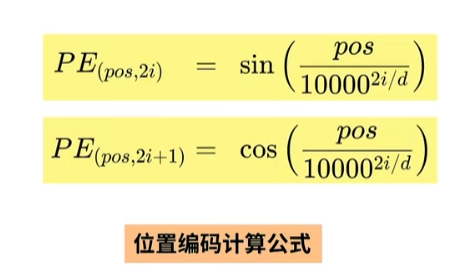<br/>奇数维度就是sin 偶数维度就是cos,使用该方法就可以让一列的值范围在-1到1，一行的值不同

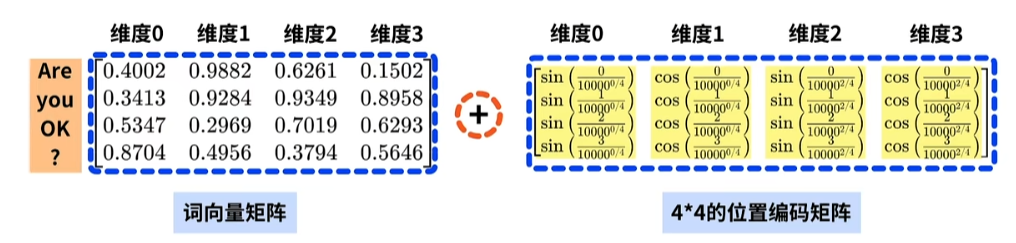

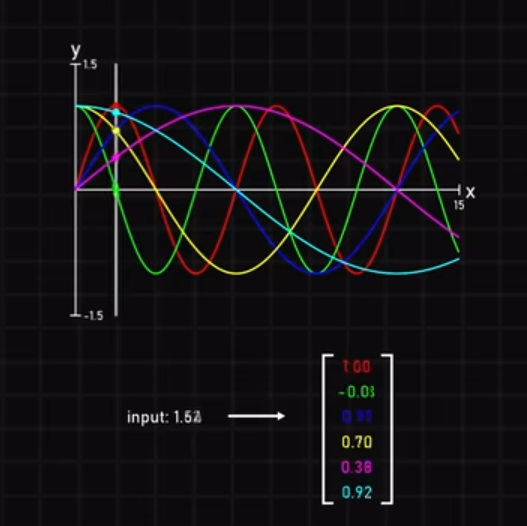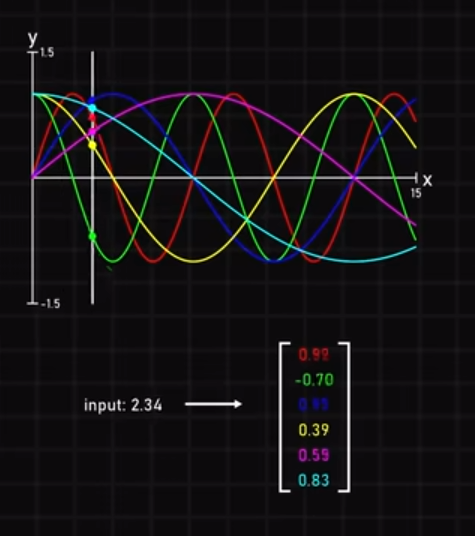<br/>上面这张图就是矩阵中的一个词的根据公式生成的4个维度

为什么位置编码要是这个公式，不能搞简单点是123456吗?<br/>
如果位置编码是123456，
在同一纬度中下，越往下的数字越大，会造成下面的数字权重太大，以后预测出来都是这个数
在不同维度下，数字之间没分别，不同维度都是相同的数字，也就是在不同的语义或者特征下 都是一样的，不利于训练词与词之间的分别

明明就是两个矩阵相加，为什么位置编码会有效果？

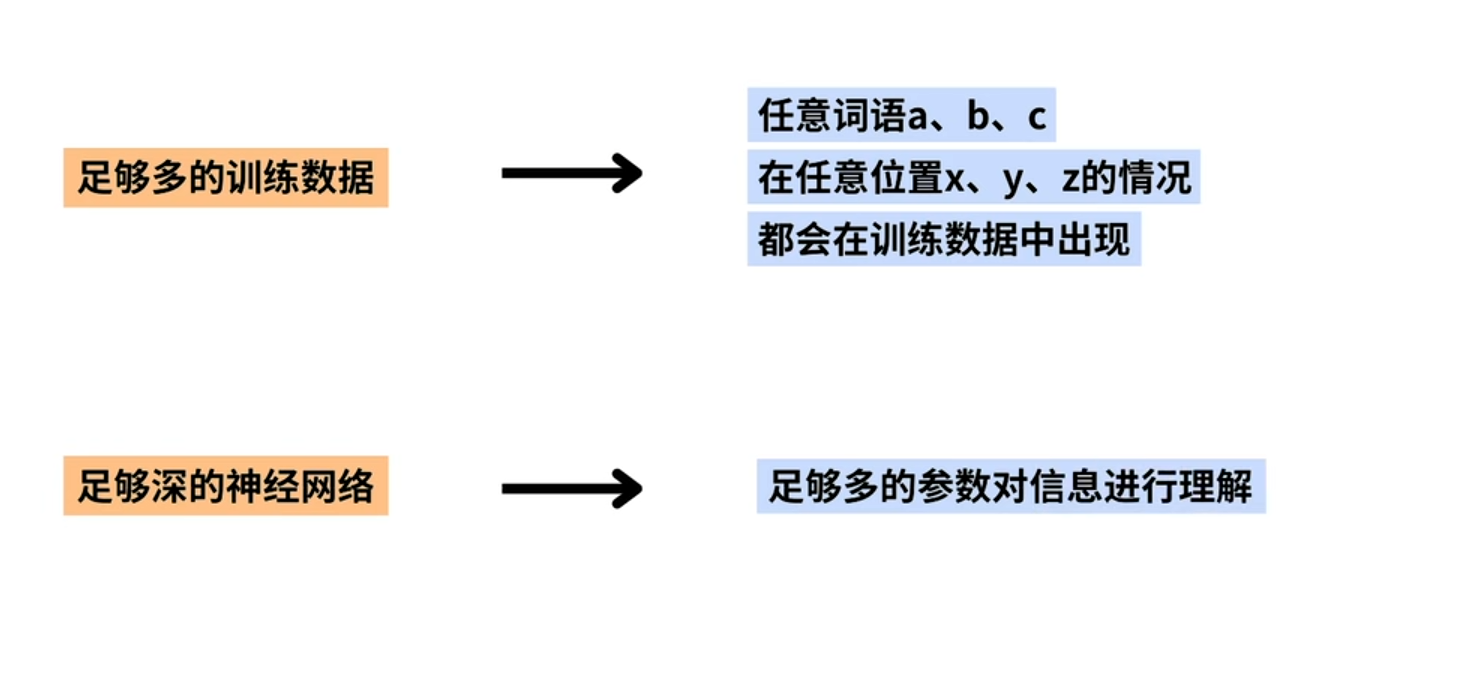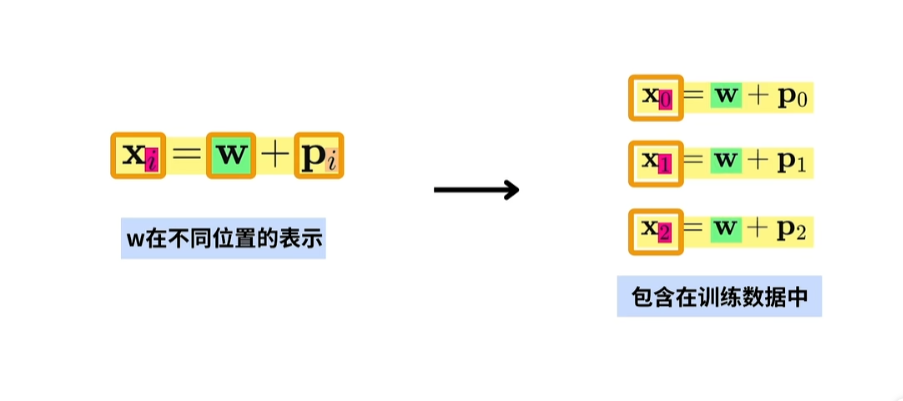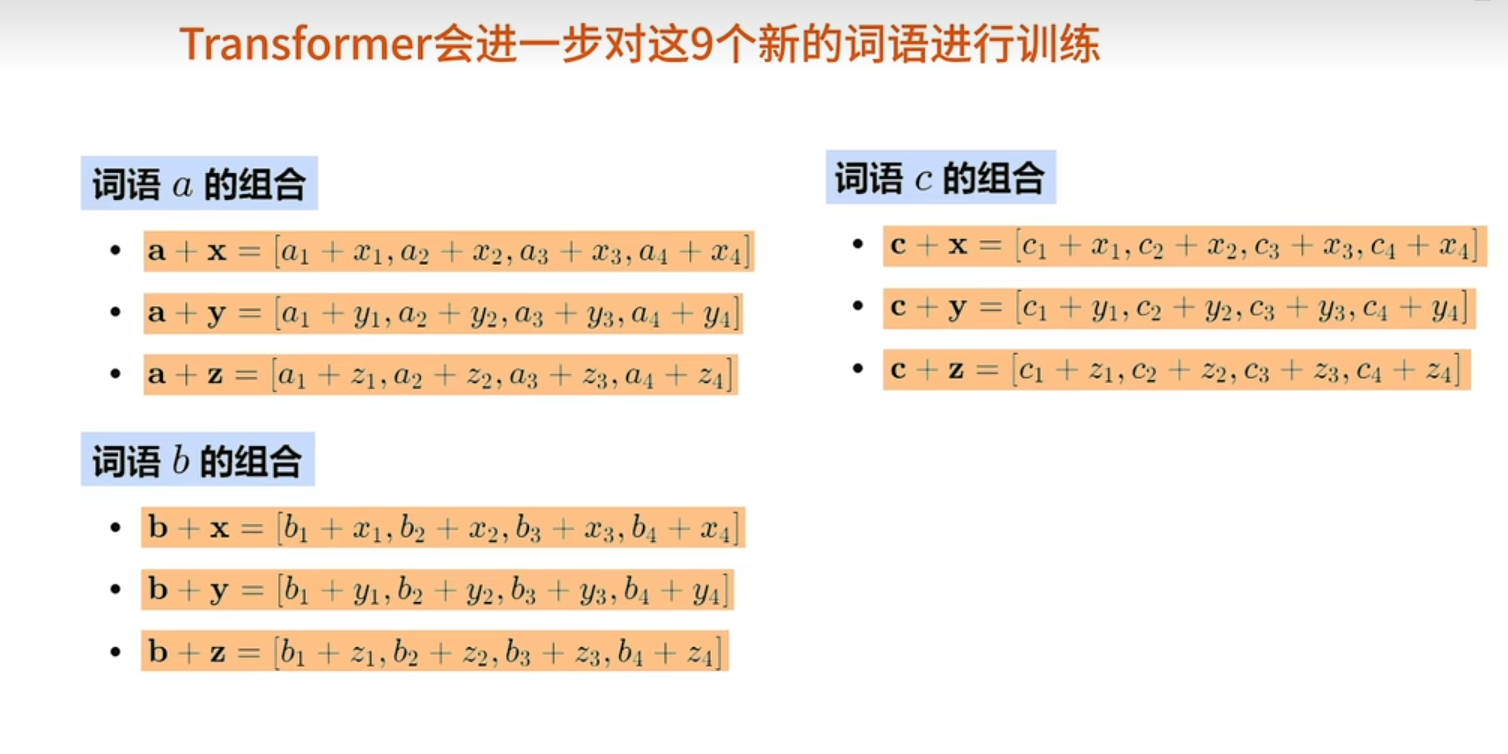<br/>x，y，z=不同维度的位置编码，类似于维度1 维度2 维度3 也是就 sin cos sin,神经网络最擅长就是kx+b的分类，换句话说就是为kx+b而生的

#### **1.创建和数据矩阵大小一样的矩阵，我们需要这两个矩阵相加**

In [25]:
#创建和数据矩阵大小一样的零矩阵，然后再加上 上面介绍的公式，得到需要的位置矩阵，然后让词汇表矩阵加上位置矩阵 ，我们需要这两个矩阵相加
position_encoding_lookup_table = torch.zeros(_context_length,_d_model)
#按0-_context_length 次序生成一个数组
position_arange =torch.arange(0,_context_length,dtype=torch.float) 
# unsqueeze(1) 含义：在第 1 维的位置上增加一个维度。这个操作会将原本的张量变成具有额外的第二维（第 1 维）的张量。
position = position_arange.unsqueeze(1)

In [26]:
#查看原来的数组和分开的数组
print(position_arange,position_arange.shape)
print(position,position.shape)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.]) torch.Size([16])
tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.]]) torch.Size([16, 1])


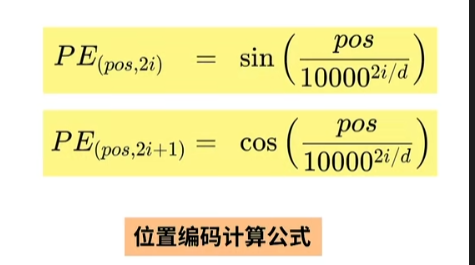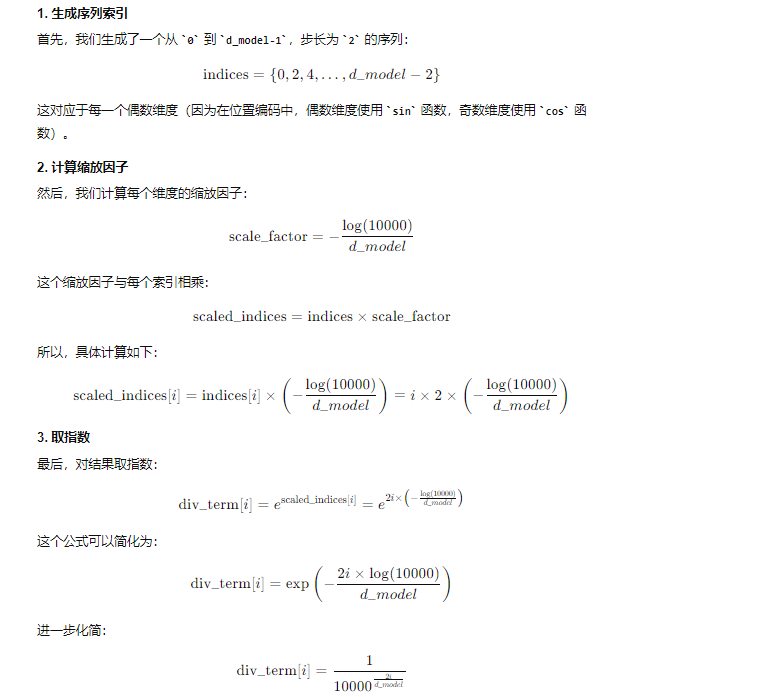

#### **2.计算各个维度的位置编码**

In [27]:
import math

#根据公式填充数组
#创建分母
#1.创建出填满2i的序列索引数列
indices =  torch.arange(0,_d_model,2).float()
indices

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
        28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50., 52., 54.,
        56., 58., 60., 62.])

In [28]:
#2.计算各个位置的维度 缩放因子
scale_factor = (-math.log(10000.0)/_d_model)
scale_factor

-0.14391156831212787

In [29]:
#3. 索引数列*缩放因子=各个索引的缩放程度 也就是 2i * (-log(100000)/_d_model)
scale_indices = indices * scale_factor
scale_indices

tensor([-0.0000, -0.2878, -0.5756, -0.8635, -1.1513, -1.4391, -1.7269, -2.0148,
        -2.3026, -2.5904, -2.8782, -3.1661, -3.4539, -3.7417, -4.0295, -4.3173,
        -4.6052, -4.8930, -5.1808, -5.4686, -5.7565, -6.0443, -6.3321, -6.6199,
        -6.9078, -7.1956, -7.4834, -7.7712, -8.0590, -8.3469, -8.6347, -8.9225])

In [30]:
#4.利用e^x 与log的性质 得到位置编码的分母
#div_term = e^(2i * (-log(100000)/_d_model) = e^(log(100000 ^(-1)*(2i/_d_model))) = 100000^(-2i/_d_model)
div_term = torch.exp(scale_indices)
div_term

tensor([1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
        1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
        3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
        5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
        1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
        1.7783e-04, 1.3335e-04])

In [31]:
#  上下文的索引矩阵 * 单个维度的所有位置特征值 =  上下文行*_d_model维度的位置信息=所需要的位置Embedding
position_div_term =  position * div_term 
position_div_term 

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
         1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
         3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
         5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
         1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
         1.7783e-04, 1.3335e-04],
        [2.0000e+00, 1.4998e+00, 1.1247e+00, 8.4339e-01, 6.3246e-01, 4.7427e-01,
         3.5566e-01, 2.6670e-01, 2.0000e-

In [32]:
#替换原来的位置 奇数位置Embedding
position_encoding_lookup_table[0:len(position_encoding_lookup_table),0::2] = torch.sin(position_div_term)
#替换原来的位置 偶数位置Embedding
position_encoding_lookup_table[0:len(position_encoding_lookup_table),1::2] = torch.cos(position_div_term)

In [33]:
print(position_encoding_lookup_table,position_encoding_lookup_table.shape)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
          1.3335e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
          2.6670e-04,  1.0000e+00],
        ...,
        [ 4.2017e-01,  9.0745e-01, -3.1822e-01,  ...,  1.0000e+00,
          1.7336e-03,  1.0000e+00],
        [ 9.9061e-01,  1.3674e-01, -8.7899e-01,  ...,  1.0000e+00,
          1.8669e-03,  1.0000e+00],
        [ 6.5029e-01, -7.5969e-01, -9.6821e-01,  ...,  1.0000e+00,
          2.0003e-03,  1.0000e+00]]) torch.Size([16, 64])


In [34]:
# 为了在后续操作中方便处理，可以添加一个 batch 维度

#   unsqueeze(dim)：

# unsqueeze 函数在指定的维度 dim 上增加一个大小为 1 的新维度。
# unsqueeze(0)：

# 0 代表第 0 维，即在张量的最前面添加一个新的维度。
# 原本的张量的形状将会发生变化，新增的维度大小为 1，其他维度保持不变。
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0)  # 形状变为 (1, seq_len, d_model)

In [35]:
print(position_encoding_lookup_table,position_encoding_lookup_table.shape)

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
           1.3335e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
           2.6670e-04,  1.0000e+00],
         ...,
         [ 4.2017e-01,  9.0745e-01, -3.1822e-01,  ...,  1.0000e+00,
           1.7336e-03,  1.0000e+00],
         [ 9.9061e-01,  1.3674e-01, -8.7899e-01,  ...,  1.0000e+00,
           1.8669e-03,  1.0000e+00],
         [ 6.5029e-01, -7.5969e-01, -9.6821e-01,  ...,  1.0000e+00,
           2.0003e-03,  1.0000e+00]]]) torch.Size([1, 16, 64])


In [36]:
# position_encoding_lookup_table.expand(_batch_size,-1,-1) =  直接复制 原来的3维矩阵 * _batch_size 为一个矩阵wo
position_encoding_lookup_table = position_encoding_lookup_table.expand(_batch_size,-1,-1)

In [37]:
position_encoding_lookup_table

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
           1.3335e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
           2.6670e-04,  1.0000e+00],
         ...,
         [ 4.2017e-01,  9.0745e-01, -3.1822e-01,  ...,  1.0000e+00,
           1.7336e-03,  1.0000e+00],
         [ 9.9061e-01,  1.3674e-01, -8.7899e-01,  ...,  1.0000e+00,
           1.8669e-03,  1.0000e+00],
         [ 6.5029e-01, -7.5969e-01, -9.6821e-01,  ...,  1.0000e+00,
           2.0003e-03,  1.0000e+00]],

        [[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
           1.3335e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
           2.6670e-04,  1.0000e+00],
         ...,
         [ 4.2017e-01,  9

#### **3.数据矩阵和位置矩阵合并**

In [38]:
#训练集 加上位置信息 
x = x_batch_embedding + position_encoding_lookup_table
#训练集的验证集 加上位置信息
y = y_batch_embedding + position_encoding_lookup_table

In [39]:
print(x,x.shape)

tensor([[[-0.1194,  0.3376,  0.4917,  ...,  0.9955, -0.1621,  0.4593],
         [-1.7577,  0.0080,  1.9785,  ..., -0.1482, -1.3868,  0.5181],
         [-0.2249, -2.6755,  0.8275,  ...,  1.2437, -1.4490,  1.0895],
         ...,
         [ 1.1029,  1.8419, -0.5877,  ...,  0.6061, -0.2836, -0.1687],
         [ 2.1150, -0.8293,  0.0262,  ...,  0.4276, -0.9608,  2.8948],
         [-0.9507, -2.2120, -2.3541,  ...,  1.9599,  0.7043, -1.0831]],

        [[ 0.9210,  1.0524, -0.2189,  ...,  1.8944, -1.2418, -0.5079],
         [-0.0071,  0.6265,  0.2410,  ..., -0.7231, -0.1052,  0.0495],
         [ 1.2031, -0.1982,  1.6211,  ...,  2.5114,  0.6799,  0.6992],
         ...,
         [ 0.4663,  0.7434,  0.1270,  ...,  1.6182,  0.0451,  2.8863],
         [ 1.0712,  0.1649, -0.1744,  ...,  0.9379, -0.3195,  1.4965],
         [ 1.5925, -0.9626, -3.1101,  ...,  0.7604,  0.0555,  0.2836]],

        [[ 1.3623, -0.0517, -1.3981,  ...,  0.6943, -1.6727,  1.1011],
         [ 0.9762,  0.5399, -0.7918,  ...,  0

In [40]:
print(y,y.shape)

tensor([[[-2.5991,  0.4677,  1.2970,  ..., -0.1482, -1.3869,  0.5181],
         [-0.2927, -1.7191,  0.5116,  ...,  1.2437, -1.4492,  1.0895],
         [ 1.5920,  0.5183,  0.7280,  ...,  0.6061, -0.2850, -0.1687],
         ...,
         [ 1.5445, -0.0586,  0.5870,  ...,  0.4276, -0.9609,  2.8948],
         [-0.6103, -1.3156, -2.2649,  ...,  1.9599,  0.7041, -1.0831],
         [ 1.0217, -1.7461, -3.2285,  ...,  1.8606,  0.1050,  2.4432]],

        [[-0.8486,  1.0862, -0.4406,  ..., -0.7231, -0.1053,  0.0495],
         [ 1.1352,  0.7582,  1.3052,  ...,  2.5114,  0.6797,  0.6992],
         [ 1.5920,  0.5183,  0.7280,  ...,  0.6061, -0.2850, -0.1687],
         ...,
         [ 0.5007,  0.9356,  0.3864,  ...,  0.9379, -0.3196,  1.4965],
         [ 1.9329, -0.0661, -3.0209,  ...,  0.7604,  0.0554,  0.2836],
         [ 0.3864, -0.7045, -0.3647,  ..., -0.6795, -0.8963, -0.9436]],

        [[ 0.1348,  0.9996, -1.4733,  ...,  0.1574, -0.7282,  0.1792],
         [ 1.5242,  1.4748,  0.4121,  ...,  0

In [41]:
#可视化x的第一个批次,也就是一个_context_length * _d_model的矩阵(都加上了位置信息)
pd.DataFrame(x[0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.119447,0.337575,0.491679,0.577978,-1.367468,0.529541,0.608181,1.436507,0.871313,0.452365,...,-2.613847,1.733103,1.868867,1.545207,-0.387398,1.531643,-0.681680,0.995529,-0.162055,0.459263
1,-1.757658,0.007958,1.978514,-1.112870,-0.076409,-0.874012,0.751056,-0.419948,-0.394310,0.588782,...,-1.003754,0.030949,-2.397691,1.975753,0.581059,-0.764739,1.805192,-0.148181,-1.386778,0.518076
2,-0.224891,-2.675503,0.827486,0.769052,1.022015,2.103486,1.761901,0.184889,-0.394995,-0.865283,...,0.512290,0.627437,0.924990,0.969820,0.488607,-0.465774,0.459785,1.243738,-1.449032,1.089512
3,0.823839,-0.055525,0.508786,-1.641579,-0.064738,-0.255055,1.584229,0.034927,1.368465,-0.118420,...,2.360710,0.870865,-0.013470,0.444770,-0.097044,3.918422,1.192544,0.606064,-0.284896,-0.168669
4,-1.163539,-1.935641,-0.723329,-0.787528,0.965095,-2.656820,1.751167,1.163293,0.298170,0.305199,...,0.817254,1.999198,-0.373688,1.542706,0.160760,2.140009,-0.286646,1.531592,-0.137891,0.626226
5,0.269043,0.314618,-0.968775,-1.941674,-0.160739,-2.249936,0.161817,-0.964677,2.117986,-1.681513,...,0.137962,0.718410,0.955590,1.488191,0.725760,2.461380,1.283890,1.204419,1.952947,0.824178
6,0.354744,0.102700,-0.703188,-0.518153,-0.394055,-2.685673,-0.674673,-1.770097,0.956829,-0.141035,...,0.879904,-0.734390,0.380841,0.616005,1.023798,2.935081,-0.342948,2.299547,-0.333210,1.718810
7,0.226023,1.467118,0.012207,-0.644076,0.445991,-0.362557,0.882389,-1.972879,1.143801,0.277605,...,0.772300,-0.093974,0.282183,-0.023074,-1.330133,-0.484757,1.738442,0.694058,-0.884678,0.235402
8,0.140790,-0.059309,-0.720812,-0.156013,-0.448343,-0.923066,1.190745,0.272591,-1.534563,-0.308191,...,-0.066721,1.020818,-0.165196,-0.388156,0.340819,1.895959,0.645343,-0.723101,-0.104272,0.049497
9,1.546858,0.170145,0.954167,0.201394,-2.064499,0.842335,-1.097561,-0.497345,-0.144056,-1.959653,...,0.068145,1.617547,0.636671,1.867032,-0.216824,3.131544,1.378882,1.355214,0.975958,2.900078


### 4.4 将位置信息放入到多头注意力机制中去（Multi-Head Attention）

#### **0.多头注意力机制的介绍。**

什么是 注意力机制？<br/>
注意力机制可以 类比为  在会议上你 根据发言内容 的 重要性 进行 记录的过程：<br/>
你会特别注意 那些引起全场关注的话题（高注意力得分）。<br/>
对于那些相对无关紧要的细节，你可能只是略过或简单记录（低注意力得分）。<br/>
这种选择性记录 就像是 注意力机制中的“注意力权重”在发挥作用。<br/>
**注意力机制通过计算每个输入位置与其他位置的相似性（通过点积计算），决定该关注哪些信息。**


什么是 多头注意力机制？<br/>
多头注意力机制可以想象为 在会议中， 你和几个同事一起倾听和记录：<br/>
每个人关注的侧重点不同，比如一个人可能特别关注财务数据，另一个人关注战略规划。<br/>
你们将各自的笔记合并，形成更全面的会议总结。这相当于将多头注意力机制的输出拼接在一起。<br/>


多头注意力机制的目标是什么？<br/>
目标是让上下文之间产生关联，有关联的/词性相关的词 彼此的距离更近，让关联不大的词彼此距离更远

实现一个多头注意力机制的流程是什么样的？<br/>
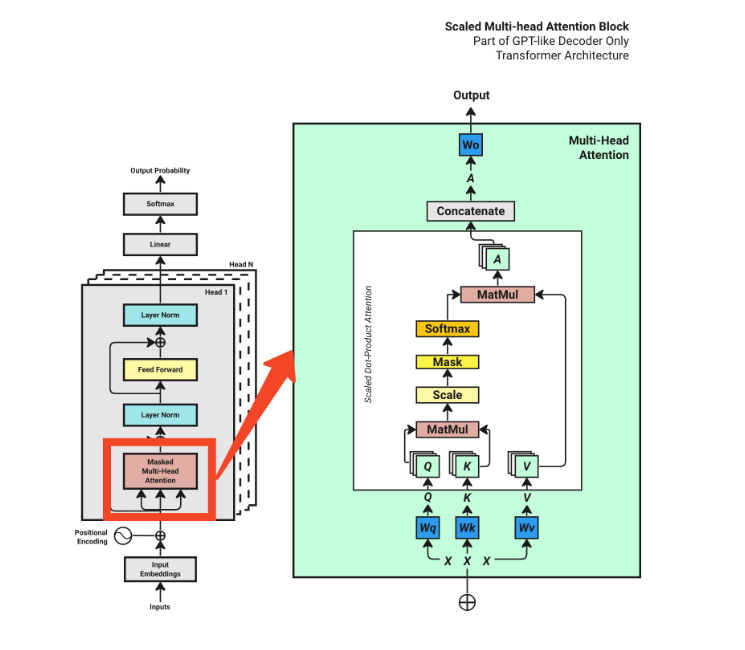

QKV是什么？<br/>

Q (Query)：查询向量，代表了模型当前在特定时刻想要聚焦的内容。它可以被理解为一个“问题”——即当前输入向量“想要”从其他向量中“寻找什么”。<br/>

K (Key)：键向量，代表了所有可能的“答案”所在的位置。每个 K 向量与 Q 向量进行比较，计算相似度，以决定每个输入向量与查询向量的相关程度。<br/>

V (Value)：值向量，代表了实际携带信息的内容。在多头注意力机制中，V 向量就是根据 Q 和 K 的相似度加权求和后的最终输出。<br/>

QK相乘之后相当于带上下文关系的关系矩阵 或者说 是对字与字之间关注度的大小的矩阵<br/>
V就是原来的矩阵，<br/>
QKV相乘就是有上下文信息的矩阵，这样就能让词与词之间有了联系

多头注意力机制中的 W_q、W_k 和 W_v  是干什么的？<br/>

W_q（Query 的权重矩阵）：<br/>
作用：帮助模型决定“我应该关注什么？”。<br/>
举例：当你看一幅画时，这个镜片帮助你选择要关注哪一部分，比如你想重点看画中的树。<br/><br/>
W_k（Key 的权重矩阵）：<br/>
作用：帮助模型理解“所有可以关注的东西是什么？”。<br/>
举例：这个镜片帮助你理解画中的所有元素，比如树、山、河流等。<br/><br/>
W_v（Value 的权重矩阵）：<br/>
作用：帮助模型决定“我从这些元素中能学到什么？”。<br/>
举例：当你选定要看的树之后，这个镜片帮助你从树上提取出颜色、形状、大小等信息。<br/>


因为w是_d_model*d_model 就是说明词与词的关系，随着训练次数的增加，给QKY的权重越准确

#### **1.创建 QKV 权重W**

In [42]:
Wq = nn.Linear(_d_model,_d_model)
Wk = nn.Linear(_d_model,_d_model)
Wv = nn.Linear(_d_model,_d_model)

#将训练集x 放入到Wq Wk Wv中/神经网络中
Q = Wq(x)
K = Wk(x)
V = Wv(x)


#打印下QKV的形状
print(Q,Q.shape,K,K.shape,V,V.shape)

#为什么矩阵形状没变?
#因为 x*w = [_context_length,_d_model] * [_d_model * _d_model] = [_context_length,_d_model]

tensor([[[ 0.5345, -0.6243, -0.2749,  ..., -0.0425,  0.1765,  0.9000],
         [ 0.2311, -0.2360,  0.1066,  ...,  0.0204,  0.1581,  1.3558],
         [-0.1589,  0.2823, -1.2451,  ..., -0.1871,  0.2445,  0.6824],
         ...,
         [-0.7381, -0.8024, -0.0929,  ..., -0.8299,  0.5075, -1.5584],
         [-0.5801, -0.8200,  0.1916,  ..., -1.9187, -0.0346, -0.8515],
         [-0.2931,  0.5991,  0.2274,  ..., -0.0062,  0.9889,  0.1871]],

        [[-0.2180, -0.1290, -0.2730,  ..., -1.1425,  0.3589,  0.4893],
         [-0.2845, -1.1634, -0.3151,  ..., -1.2766,  1.0251,  0.4776],
         [ 0.4226, -0.1131, -0.1636,  ..., -0.1845,  0.7619, -0.2210],
         ...,
         [-0.4931,  0.5880, -0.8977,  ..., -2.4619,  0.8744, -1.0762],
         [-0.0540,  0.6540, -0.4671,  ..., -0.5049,  0.3945, -1.3046],
         [-0.6236, -0.2355, -0.3020,  ..., -0.6088, -0.3823, -0.1903]],

        [[ 0.7803, -0.0999, -0.7386,  ..., -0.1548,  0.7139,  0.1994],
         [-0.2457,  0.3539, -0.8584,  ..., -0

In [43]:
#把Q,K,V根据多头的数量来切分数据
#为什么要多头？因为要增加准确性，多头相当于把一份任务交给多个人去做，这样根据可以通过多个结果来找到更接近正确的答案
#permute(0,2,1,3) 就是把矩阵变为 (_batch_size,_num_heads,_context_lenth,每个多头的特征值)=> 举个例子(4,16,4,64/4)=>(4,4,16,16)
Q = Q.reshape(_batch_size,_context_length,_num_heads,_d_model//_num_heads).permute(0,2,1,3)
K = K.reshape(_batch_size,_context_length,_num_heads,_d_model//_num_heads).permute(0,2,1,3)
V = V.reshape(_batch_size,_context_length,_num_heads,_d_model//_num_heads).permute(0,2,1,3)


print('Max Q value:', Q.max().item())
print('Min Q value:', Q.min().item())
print('Max K value:', K.max().item())
print('Min K value:', K.min().item())

print('Max V  value:', V.max().item())
print('Min V value:', V.min().item())
# print(Q,Q.shape,K,K.shape,V,V.shape)

Max Q value: 2.5832042694091797
Min Q value: -2.7662737369537354
Max K value: 2.6710116863250732
Min K value: -2.7816929817199707
Max V  value: 2.797769069671631
Min V value: -2.021695613861084


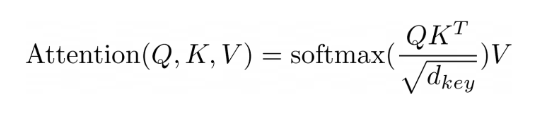

In [44]:
#根据公式 来构造函数
#MatMul=>就是Q*K(T)
#Q * K 就是 在求每个文字对应其他文字的关注度/相关度
# @=>点积相乘
# K.transpose(-2,-1)=>K(T)
matmulOutput = torch.matmul(Q, K.transpose(-2, -1))

# print(matmulOutput)
#Scale=>根号 dKey (dKey=切头后的维度) 为什么要Scale 因为矩阵相乘可能会出现很大的数，除以维度就是为了缩放
scaleOutput = matmulOutput / math.sqrt(_d_model//_num_heads)
print(scaleOutput)


tensor([[[[-6.5659e-01,  1.3079e-01, -6.0256e-01,  ...,  1.1231e-02,
           -4.5315e-02,  8.9644e-01],
          [-1.7351e-01,  8.3322e-01, -1.3076e-01,  ...,  1.3658e+00,
            9.4859e-01, -3.5882e-01],
          [ 3.1848e-01, -3.3596e-01,  2.0366e-01,  ...,  3.3848e-01,
            2.6699e-01, -8.4156e-02],
          ...,
          [-4.4657e-01,  2.6848e-01,  7.0473e-02,  ...,  1.1264e+00,
            1.2441e+00,  3.9539e-01],
          [-6.4003e-01,  1.1106e+00, -4.6239e-01,  ...,  4.7526e-01,
            6.4594e-01,  4.7797e-01],
          [ 3.4233e-02, -4.5321e-01, -3.6269e-01,  ..., -7.3385e-01,
           -1.0151e+00, -6.1026e-01]],

         [[ 3.1508e-01, -3.8256e-01, -8.5595e-02,  ..., -3.7043e-02,
           -6.2521e-02,  8.0517e-01],
          [-1.3576e-01,  1.5861e-01,  8.4183e-01,  ...,  5.3393e-01,
            1.5694e+00,  3.4823e-01],
          [-9.5705e-02,  1.9802e-01, -2.8231e-02,  ..., -4.7127e-01,
           -4.6251e-01,  3.2661e-01],
          ...,
     

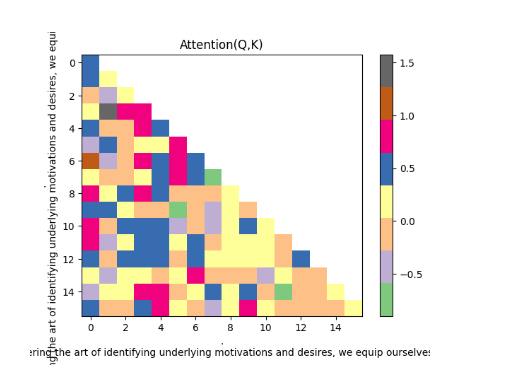

In [45]:
#因为是训练的代码，我们还需要做一个Mask操作
#什么是Mask？mask就是当前的生成的语句，不能看到后面文字的内容
# 掩码的作用是对每个时间步（词）进行遮挡，防止模型看到它后面的内容。因此，掩码必须覆盖整个序列的所有词之间的关系。

# 第一步：创建一个全为 1 的矩阵

ones_matrix = torch.ones(_context_length, _context_length)
# ones_matrix
# tensor([[1., 1., 1., 1., 1.],
#         [1., 1., 1., 1., 1.],
#         [1., 1., 1., 1., 1.],
#         [1., 1., 1., 1., 1.],
#         [1., 1., 1., 1., 1.]])


# 第二步：提取上三角矩阵，排除主对角线
# diagonal=1：表示从主对角线的上方第一条对角线开始保留元素，主对角线上的元素不保留，只保留主对角线上方的元素。
upper_triangular = torch.triu(ones_matrix, diagonal=1)
# upper_triangular
# tensor([[0., 1., 1., 1., 1.],
#         [0., 0., 1., 1., 1.],
#         [0., 0., 0., 1., 1.],
#         [0., 0., 0., 0., 1.],
#         [0., 0., 0., 0., 0.]])

# 第三步：将矩阵转换为布尔类型
mask = upper_triangular.bool()
# mask
# tensor([[False,  True,  True,  True,  True],
#         [False, False,  True,  True,  True],
#         [False, False, False,  True,  True],
#         [False, False, False, False,  True],
#         [False, False, False, False, False]])


# 应用 mask这样就遮盖了上对角线上的数据
maskOutput = scaleOutput.masked_fill(mask,float('-inf'))

# Masked Output:
#  tensor([[ 0.5000,   -inf,   -inf,   -inf,   -inf],
#         [ 0.2000,  0.3000,   -inf,   -inf,   -inf],
#         [ 0.4000,  0.7000,  0.6000,   -inf,   -inf],
#         [ 0.1000,  0.2000,  0.3000,  0.4000,   -inf],
#         [ 0.3000,  0.4000,  0.5000,  0.6000,  0.7000]])

#maskOutput[0,0]=>[上下文，特征值]
pd.DataFrame(maskOutput[0,0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.656592,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.173507,0.833224,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,0.318476,-0.335963,0.203661,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,-0.492708,0.042932,-0.117577,1.516242,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.397832,0.521797,0.230773,0.360768,0.209958,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,-1.301716,-0.170852,-0.326692,0.401797,-0.419564,0.292733,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-1.201070,0.494924,-0.254192,-0.192539,-0.619008,0.216151,-0.391474,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,-0.580649,0.077059,0.115898,-0.485113,-0.147201,-0.647467,-1.078872,-0.178883,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.808918,0.872708,-0.010831,-0.267348,-0.070427,-0.168164,-0.664974,0.568086,-0.119097,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.939438,0.550253,0.309611,-0.316445,-0.023102,-0.548801,-0.910315,0.544976,-0.129986,-0.945147,-inf,-inf,-inf,-inf,-inf,-inf


In [46]:
# import torch.nn.functional as F
#softmax
attention_score = F.softmax(maskOutput,dim=-1)
attention_score.shape
pd.DataFrame(attention_score[0,0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.267620,0.732380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.414720,0.215544,0.369736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.086064,0.147045,0.125239,0.641652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.209623,0.237289,0.177373,0.201996,0.173719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.051061,0.158203,0.135374,0.280488,0.123368,0.251506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.050166,0.273510,0.129312,0.137535,0.089784,0.206969,0.112724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.094185,0.181811,0.189011,0.103627,0.145286,0.088097,0.057228,0.140756,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.046694,0.250946,0.103720,0.080253,0.097720,0.088621,0.053923,0.185048,0.093077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.042647,0.189171,0.148712,0.079516,0.106623,0.063029,0.043907,0.188175,0.095814,0.042404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
#点乘V
attention_output = attention_score @ V

attention_output
# attention_output.shape

tensor([[[[-5.6793e-01,  1.2459e-01, -1.9927e-01,  ...,  1.9759e-01,
            6.4410e-01, -1.8246e-01],
          [-2.5988e-01,  1.3752e+00, -3.3022e-01,  ..., -3.2708e-01,
            1.6915e+00, -5.7367e-01],
          [ 2.3497e-01,  7.2159e-01,  2.1567e-01,  ...,  4.4168e-02,
            9.8661e-01,  4.4893e-02],
          ...,
          [-3.9869e-02,  3.4138e-01,  1.7166e-01,  ..., -4.5877e-01,
            3.5680e-01,  6.5885e-01],
          [-1.9856e-02,  4.5550e-01,  2.1292e-01,  ..., -4.3098e-01,
            5.4133e-01,  4.1256e-01],
          [ 1.6164e-02,  3.8296e-01,  2.0216e-01,  ..., -2.9670e-01,
            3.2537e-01,  4.7184e-01]],

         [[ 2.8147e-01,  9.6013e-01, -3.3605e-01,  ..., -4.7352e-01,
           -1.5643e-01,  1.7166e-01],
          [-7.4990e-01,  1.1801e+00, -3.2564e-01,  ..., -1.2229e-01,
           -8.1025e-03,  3.2507e-01],
          [-4.4765e-01,  1.1715e+00, -3.7076e-01,  ..., -2.6526e-02,
            1.7506e-01,  4.8794e-01],
          ...,
     

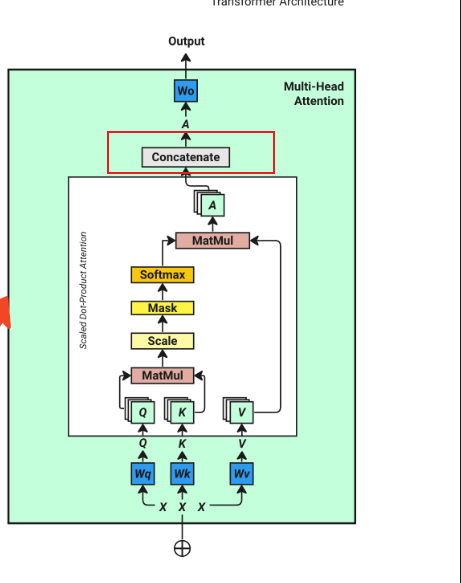

In [48]:
#concatenate
# 把之前调整了的矩阵再调整回来，因为要合并了
# #permute(0,2,1,3) 举个例子(4,多头,16,特征值)=>(4,16,多头,特征值)
attention_output = attention_output.transpose(1,2)
# 把多头合并
attention_output_merge = attention_output.reshape(_batch_size,-1,_d_model)

attention_output_merge.shape

torch.Size([4, 16, 64])

In [49]:
# Wq（Query 权重矩阵）：用于将输入的序列表示（通常是嵌入向量）映射到查询（Query）向量空间。

# Wk（Key 权重矩阵）：用于将输入的序列表示映射到键（Key）向量空间。

# Wv（Value 权重矩阵）：用于将输入的序列表示映射到值（Value）向量空间。

# 这些矩阵在自注意力机制中用于生成查询、键和值向量，然后计算注意力得分和加权平均值。

# Wo（Output 权重矩阵）：在计算了加权的值向量后，Wo 用于将这些加权的值向量映射回原始的特征空间。具体来说，Wo 矩阵的作用是在自注意力机制的输出上应用一个线性变换。这是为了将注意力机制的输出与输入的维度对齐，并生成最终的输出表示。
# 总结起来：

# Wq、Wk、Wv 是用来从输入中提取查询、键和值向量的。
# Wo 是用来将经过注意力机制计算后的值向量转换回原始维度的。


# 为什么还需要 Wo 矩阵？
# Wo 矩阵是一个线性变换，用于将多头注意力的合并结果映射到模型的目标维度。这一变换 是 可训练的 ，并且优化了模型的表示能力。
# 即使注意力输出已经被合并为 (batch_size, sequence_length, d_model)，Wo 矩阵会在这一阶段进一步调整输出，以确保它能够正确地融入到模型的其他部分。
Wo  = nn.Linear(_d_model,_d_model)
attention_output_merge_wo = Wo(attention_output_merge)
attention_output_merge_wo.shape


torch.Size([4, 16, 64])

In [50]:
#加上一个残差链接
#如果有了残差连接，就会在稳定的范围内去找，没有的话就会更大范围的去找，可能会出现梯度爆炸/梯度消失
# x : 训练集 加上位置信息 
attention_output_merge_wo = attention_output_merge_wo + x 

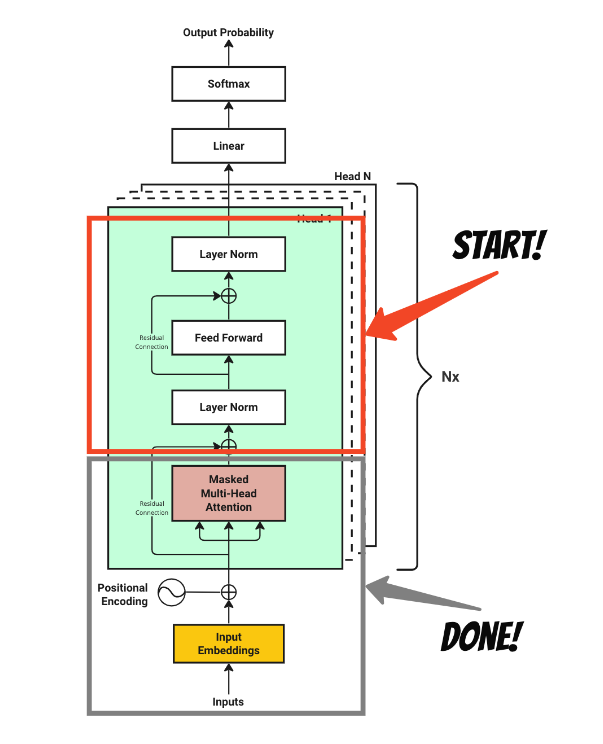

In [51]:
# 层归一化（Layer Normalization, LN）是一种正则化技术，主要用于深度学习模型中的神经网络层，以稳定训练过程并加速模型收敛。
# 在Transformer和其他神经网络模型中，层归一化是一个重要的组件，它对每个输入样本的隐藏状态进行归一化处理

#层归一化
layer_norm = nn.LayerNorm(_d_model)
layer_norm_output_1  = layer_norm(attention_output_merge_wo)


# 多头注意力机制之后加入前馈神经网络的主要目的是通过非线性变换、独立特征建模、特征转换和增强等手段，进一步丰富模型的表达能力，从而提升模型的整体性能。
# 这两者的结合使得Transformer在处理自然语言等复杂任务时表现得非常强大。

#前馈神经网络
# 前馈神经网络通过扩展-激活-收缩的设计，使得模型具备了更强的特征学习和表达能力。它能够独立地为每个输入位置进行复杂的处理和增强，使得Transformer在语言建模等任务中表现得非常出色。
# 这种结构虽然简单，但却极大地提升了模型的深度、灵活性和整体性能。



# 前馈神经网络（Feed-Forward Neural Network, FFN）在Transformer中的设计，通常是由两个线性层和一个非线性激活函数组成。其具体结构如下：

# 第一个线性层将输入向量的维度从 d_model 扩展到更高的维度，通常是 4 * d_model。
# 激活函数（例如 ReLU、GELU）应用在扩展的向量上，增加非线性。
# 第二个线性层将维度缩回原始的 d_model，与前馈神经网络的输入对齐。
# 1. 维度扩展与特征学习
# 前馈神经网络的第一个线性层将维度扩展到 4 * d_model，提供了一个更大的空间用于学习和表达更丰富的特征。
# 这种维度扩展相当于增加了模型处理每个输入向量的能力，使得网络可以在更高维度空间中学习更复杂的特征。

# 2. 非线性激活函数，提升表达能力
# 非线性激活函数（例如 ReLU 或 GELU）是深度神经网络的核心，能够打破线性结构的限制，增强模型的表达能力。
# 通过引入非线性，FFN可以捕捉到输入中更复杂的模式和特征，这在语言理解和生成任务中是至关重要的。
forward_output = nn.Linear(_d_model,_d_model*4)(layer_norm_output_1)
forward_output = nn.ReLU()(forward_output)
forward_output = nn.Linear(_d_model*4,_d_model)(forward_output)

# 加个残差网络
forward_output = forward_output + layer_norm_output_1
print(forward_output)
#再加个层归一化
layer_norm_output_2  =  layer_norm(forward_output)


tensor([[[-0.3416,  0.0480, -0.6535,  ...,  0.5433, -1.3430,  0.9407],
         [-2.1829, -0.3370,  1.1145,  ..., -0.3246, -1.4879,  1.0142],
         [-1.0292, -3.2488,  0.9073,  ...,  1.0113, -2.0320,  1.4623],
         ...,
         [ 0.7128,  0.5610, -0.7969,  ..., -0.2224, -0.9838,  0.1144],
         [ 0.9594, -1.1462,  0.1946,  ..., -0.2874, -0.9901,  2.2743],
         [-1.2788, -2.8646, -1.8898,  ...,  1.6667,  0.2398, -0.5176]],

        [[-0.1715,  0.5526, -0.3536,  ...,  1.8465, -1.4718, -0.7807],
         [-1.2323,  0.1611, -0.1985,  ..., -0.7993, -0.6925, -0.2066],
         [-0.3386, -0.7617,  1.1831,  ...,  1.9382, -0.3099,  0.4725],
         ...,
         [-0.4405, -0.3468, -0.0045,  ...,  1.1096, -0.4275,  2.3390],
         [ 0.1487, -0.3332, -0.2306,  ...,  0.7934, -0.9499,  1.1901],
         [ 0.4706, -1.3393, -2.8608,  ...,  0.5637, -0.6260,  0.2795]],

        [[ 0.8140, -0.4268, -1.7321,  ...,  0.3517, -2.1821,  1.6484],
         [ 0.5171, -0.2433, -1.5899,  ...,  0

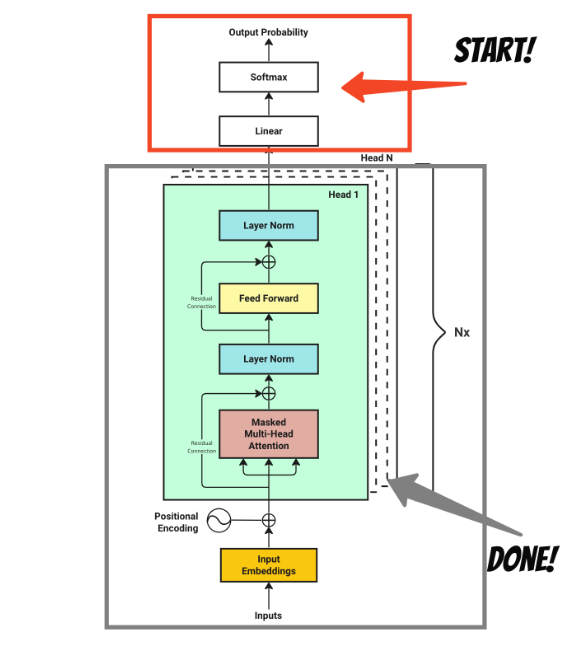

In [52]:
# 找到在数据集中 字母对应向量 中最大的值 +1 (因为是索引值) 这个值后 在我们构建inputEmbedded的时候会当作行向量的最大值
# d_model=>max_token_value+1

# 目标是将这些高维特征转换为词汇表中每个词的概率分布，从而生成最终的输出词汇。这是通过一个全连接层（nn.Linear）实现的。
# 这个全连接层将隐藏层的特征映射到词汇表的大小，即 max_token_value + 1，每一个值代表词汇表中某个词汇的得分。

# 3. 举例说明
# 假设 _d_model = 64，max_token_value + 1 = 10000：

# 对于一个长度为 64 的输入特征向量 x，它将与每个词汇对应的权重向量（长度 64）点积得到一个值，这个值就是该词的得分。
# 例如：
# x 乘以权重矩阵的第一列，得到词汇表中第一个词的得分。
# x 乘以权重矩阵的第二列，得到词汇表中第二个词的得分。
# 这个过程会对词汇表中的每个词进行，生成一个长度为 10000 的输出向量 y。

output = nn.Linear(_d_model,max_token_value+1)(layer_norm_output_2)
output.shape
output

tensor([[[ 0.3537,  0.8655,  0.3501,  ...,  0.4863, -0.1938,  0.2545],
         [ 0.4334, -0.4717, -0.0484,  ...,  0.2039, -0.2492,  0.7865],
         [-0.6849, -0.5397,  0.8406,  ...,  0.4122,  0.0779,  0.8452],
         ...,
         [-0.7094,  0.4358,  0.2897,  ...,  0.5412, -0.0571,  0.6010],
         [-0.0702,  0.8231,  0.6293,  ...,  0.8607, -0.8092,  0.2391],
         [-0.0228,  1.0128, -0.1789,  ..., -0.3265, -0.4062, -0.8472]],

        [[-1.2370, -0.8315,  0.4590,  ..., -0.1023, -0.2771,  0.4981],
         [-0.5907, -0.2503,  0.4430,  ..., -0.7844, -0.3293, -0.2425],
         [-0.8901, -0.9184,  1.0265,  ..., -0.4407,  0.4533,  0.7172],
         ...,
         [-0.5237,  0.0785,  0.8525,  ..., -0.2679, -0.3003,  0.3863],
         [-0.6624, -0.4724,  0.3056,  ...,  0.1758, -0.4006,  0.1292],
         [-0.3804,  0.4360,  0.1024,  ..., -0.3347, -0.3542, -0.7887]],

        [[-0.9960,  0.5557,  0.2781,  ...,  0.6999,  0.7263,  0.7204],
         [-0.2135, -0.6115, -0.1366,  ...,  1

In [53]:
#把字典值变为概率
logits = F.softmax(output,dim=-1)

predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' TCHAR'